<a href="https://colab.research.google.com/github/Romanchenko-RS/ML/blob/main/%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D0%BE%D0%B9_%D1%81%D0%B5%D1%82%D0%B8_%D0%BD%D0%B0_%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B5_%D0%A0%D0%BE%D0%BC%D0%B0%D0%BD%D1%87%D0%B5%D0%BD%D0%BA%D0%BE_%D0%A0_%D0%A1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание

Классификация изображений: Cats vs Dogs
Обучить модель классификации изображение на 2 класса. Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs. Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. Задание засчитывается при значениях метрики Log Loss меньше 0.3.

# Импорт необходимых библиотек

In [7]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16
import os
from random import shuffle
from glob import glob
from matplotlib import pyplot as plt
import re

# Получение данных

In [8]:
# Разархивируем основной архив
!unzip -o dogs-vs-cats-redux-kernels-edition.zip -d /content/

Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: /content/sample_submission.csv  
  inflating: /content/test.zip       
  inflating: /content/train.zip      


In [9]:
# Получаем train данные
!unzip -o /content/train.zip -d /content/train/

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/train/train/dog.5499.jpg  
  inflating: /content/train/train/dog.55.jpg  
  inflating: /content/train/train/dog.550.jpg  
  inflating: /content/train/train/dog.5500.jpg  
  inflating: /content/train/train/dog.5501.jpg  
  inflating: /content/train/train/dog.5502.jpg  
  inflating: /content/train/train/dog.5503.jpg  
  inflating: /content/train/train/dog.5504.jpg  
  inflating: /content/train/train/dog.5505.jpg  
  inflating: /content/train/train/dog.5506.jpg  
  inflating: /content/train/train/dog.5507.jpg  
  inflating: /content/train/train/dog.5508.jpg  
  inflating: /content/train/train/dog.5509.jpg  
  inflating: /content/train/train/dog.551.jpg  
  inflating: /content/train/train/dog.5510.jpg  
  inflating: /content/train/train/dog.5511.jpg  
  inflating: /content/train/train/dog.5512.jpg  
  inflating: /content/train/train/dog.5513.jpg  
  inflating: /content/train/train/dog.5514.jpg  
  inf

In [10]:
# Получаем test данные
!unzip -o /content/test.zip -d /content/test/

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/test/test/5499.jpg  
  inflating: /content/test/test/55.jpg  
  inflating: /content/test/test/550.jpg  
  inflating: /content/test/test/5500.jpg  
  inflating: /content/test/test/5501.jpg  
  inflating: /content/test/test/5502.jpg  
  inflating: /content/test/test/5503.jpg  
  inflating: /content/test/test/5504.jpg  
  inflating: /content/test/test/5505.jpg  
  inflating: /content/test/test/5506.jpg  
  inflating: /content/test/test/5507.jpg  
  inflating: /content/test/test/5508.jpg  
  inflating: /content/test/test/5509.jpg  
  inflating: /content/test/test/551.jpg  
  inflating: /content/test/test/5510.jpg  
  inflating: /content/test/test/5511.jpg  
  inflating: /content/test/test/5512.jpg  
  inflating: /content/test/test/5513.jpg  
  inflating: /content/test/test/5514.jpg  
  inflating: /content/test/test/5515.jpg  
  inflating: /content/test/test/5516.jpg  
  inflating: /content/test/test/5

# Подготовка данных для обучения

In [16]:
train_files = glob('/content/train/train/*.jpg')
test_files = glob('/content/test/test/*.jpg')

In [14]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        if len(files) == 0:
            raise ValueError("The file list is empty, please check your data.")
        for k in range(max(1, len(files) // batch_size)):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

def predict_generator(files):
    batch_size = 32  # определяем размер батча для предсказаний
    if len(files) == 0:
        raise ValueError("The file list is empty, please check your data.")
    while True:
        for i in range(0, len(files), batch_size):
            batch_files = files[i:i + batch_size]
            x = np.array([load_image(path) for path in batch_files])
            yield (x,)

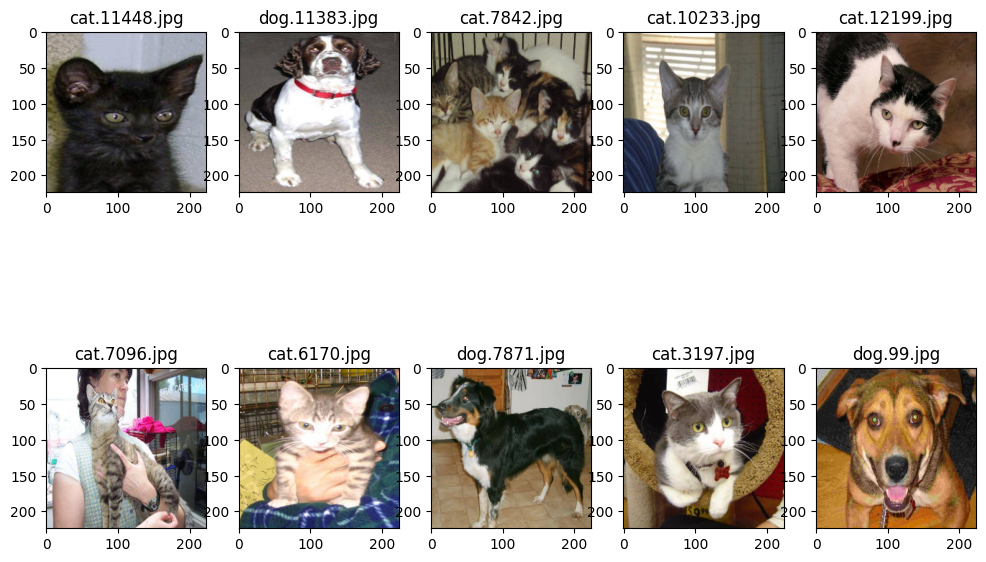

In [17]:
# Выведем изображения
%matplotlib inline
fig = plt.figure(figsize=(12, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

Используем предобученную модель

In [18]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.summary()

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Model: "dogs_vs_cats"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             5

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Обучение модели

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

val_samples = 5  # число изображений в валидационной выборке
shuffle(train_files)
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])

model.fit(train_data, steps_per_epoch=20, epochs=8, validation_data=validation_data)
model.save('cats-dogs-vgg16.hdf5')

Epoch 1/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 347s 17s/step - accuracy: 0.5228 - loss: 2.0329 - val_accuracy: 0.8000 - val_loss: 0.1850
Epoch 2/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 350s 18s/step - accuracy: 0.7535 - loss: 0.8535 - val_accuracy: 1.0000 - val_loss: 0.0724
Epoch 3/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 345s 17s/step - accuracy: 0.8940 - loss: 0.3394 - val_accuracy: 1.0000 - val_loss: 0.0452
Epoch 4/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 348s 17s/step - accuracy: 0.9007 - loss: 0.3849 - val_accuracy: 1.0000 - val_loss: 0.0261
Epoch 5/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 345s 17s/step - accuracy: 0.9243 - loss: 0.2107 - val_accuracy: 1.0000 - val_loss: 0.0305
Epoch 6/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 350s 17s/step - accuracy: 0.9296 - loss: 0.1917 - val_accuracy: 1.0000 - val_loss: 0.0245
Epoch 7/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 355s 18s/step - accuracy: 0.9504 - loss: 0.1804 - val_accuracy: 1.0000 - val_loss: 0.0173
Epoch 8/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 345s 17s/step - accuracy: 0.9567 - loss: 0.1616 - val_accuracy: 1.0000 - v

Выполним генерацию предсказаний

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 6661s 533ms/step


<ipython-input-20-ac69b35a317c>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  subplot.set_title('%.2f %s' % (score, os.path.basename(path)))


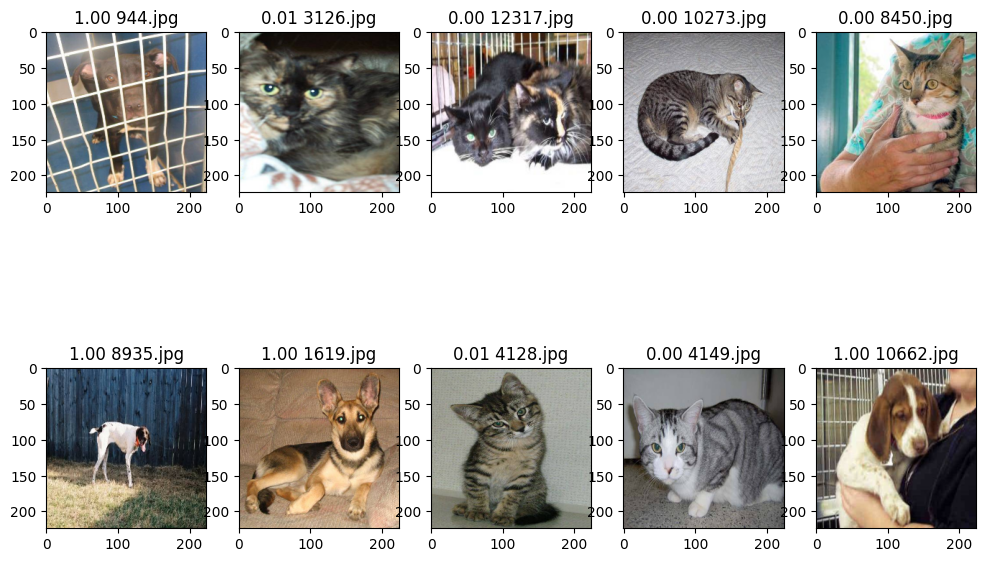

In [20]:
def predict_generator(files):
    if len(files) == 0:
        raise ValueError("The file list is empty, please check your data.")
    while True:
        for path in files:
            yield (np.array([load_image(path)]),)  # возвращаем кортеж

test_pred = model.predict(predict_generator(test_files), steps=len(test_files))
fig = plt.figure(figsize=(12, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

# Сохраним результат в файл для проверки

In [21]:
with open('result.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        score = score[0]  # извлекаем значение из массива
        img_id = re.search(r'(\d+)\.jpg$', path).group(1)
        dst.write(f'{img_id},{score:.6f}\n')

In [22]:
from google.colab import files
files.download('result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Выводы

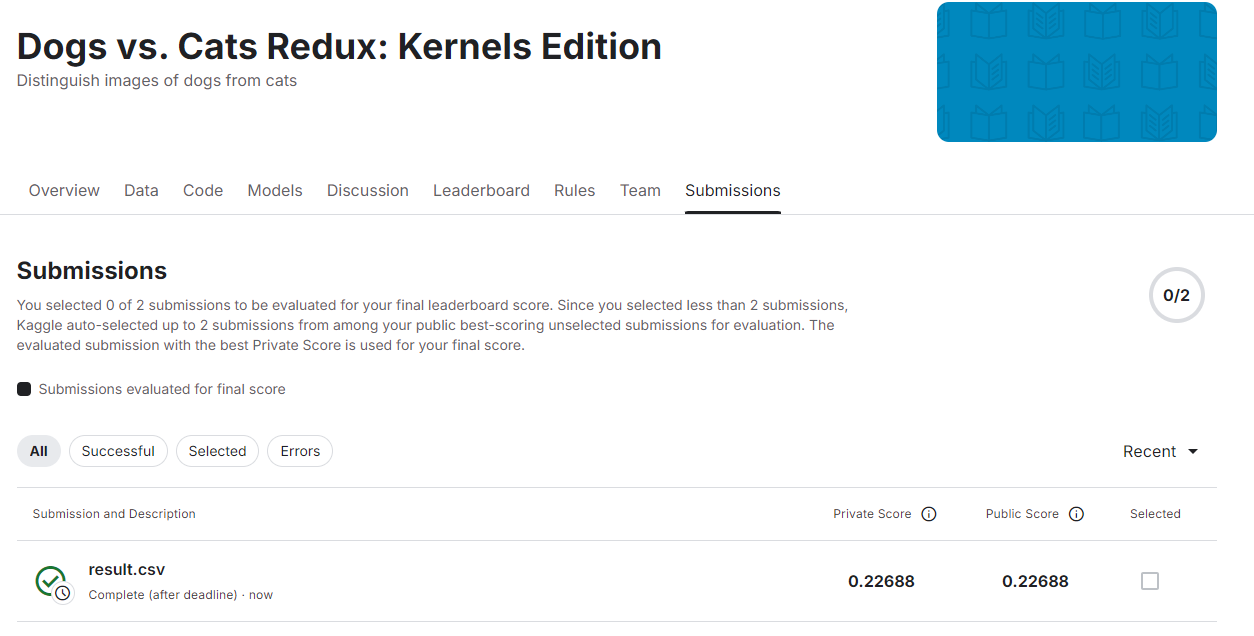

Видим, что полученная модель отвечает заданным критериям качества. При визуальном анализе 10 случайных элементов все были верно классифицированы.

Для увеличения качества необходимо провести обучение на большем количестве эпох, но в данном случае это не требуется.